<a href="https://colab.research.google.com/github/Brettbian/SeniorThesis/blob/main/Residual_GAN_uniform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import time
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
tf.random.set_seed(111)

In [ ]:
# ! sudo apt-get install texlive-latex-recommended 
# !apt install cm-super

In [ ]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

In [ ]:
#generate the unifrom distribution on [0,1] x [0,0.5] as the true data distribution
BUFFER_SIZE = 5000
BATCH_SIZE = 100
x_data = tf.random.uniform([1000,2],minval = [0,0], maxval = [1,0.5], dtype='float32')

plt.scatter(x_data[:,0],x_data[:,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(r'$\bf Distribution\ of\ True\ Data$', fontsize=11)
plt.xlabel(r'$\mathbf{x_1}$', fontsize=11)
plt.ylabel(r'$\mathbf{x_2}$', fontsize=11)
ax = plt.axes()
ax.set_facecolor("white")
ax.grid(True, color = 'black', linewidth = 0.1)

plt.savefig('True Uniform Distribution.png', bbox_inches='tight')


train_dataset = tf.data.Dataset.from_tensor_slices(x_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


In [ ]:
#generate the fake distribution as uniform
noise = tf.random.uniform([1000,2],minval = [0,0.5], maxval = [1,1], dtype='float32')
plt.scatter(noise[:,0],noise[:,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(r'$\bf Distribution\ of\ Fake\ Data$', fontsize=11)
plt.xlabel(r'$\mathbf{x_1}$', fontsize=11)
plt.ylabel(r'$\mathbf{x_2}$', fontsize=11)
ax = plt.axes()
ax.set_facecolor("white")
ax.grid(True, color = 'black', linewidth = 0.1)

plt.savefig('Fake Uniform Distribution.png', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


In [ ]:
#define generator
n_g_layers = 20
dt = 0.1
x0 = Input((2))
x = x0
states_G = [x]
for _ in range(n_g_layers):
    x = x + dt * Dense(2, activation='tanh')(x)
    states_G.append(x)
model_generator = tf.keras.Model(x0, x)

In [ ]:
# #define dummy generator
# x0 = Input((2))
# model_generator = tf.keras.Model(x0, x0)

In [ ]:
#define discriminator
n_d_layers = 20
dt = 0.1
x1 = Input((2))
x = x1
states_D = [x]
n_d_layers = 20
for _ in range(n_d_layers):
    x = x + dt * Dense(2, activation='tanh')(x)
    states_D.append(x)
last_layer = Dense(1, activation='sigmoid', trainable=False)
y = last_layer(x)
model_discriminator = tf.keras.Model(x1, y)

In [ ]:
# #define dummy discriminator
# x1 = Input((2))
# y = Dense(1, activation='sigmoid', trainable=False)(x)
# model_discriminator = tf.keras.Model(x, y)
# a = np.array([[0],[-1]])
# b = np.array([0.5])
# c = [a,b]
# print(c)
# model_discriminator.layers[1].set_weights(c)

In [ ]:
#test the untrained discriminator
test_noise = tf.random.uniform([2,2],dtype='float32')
predict = model_discriminator.predict(test_noise)
print(predict, test_noise)

[[0.49484733]
 [0.34953678]] tf.Tensor(
[[0.49884057 0.05265665]
 [0.38048363 0.45821965]], shape=(2, 2), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
  
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [ ]:
EPOCHS = 50
noise_dim = 2
num_examples_to_generate = 1000
noise = tf.random.uniform([num_examples_to_generate,noise_dim],minval = [0,0.5], maxval = [1,1], dtype='float32')

In [ ]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=model_generator,
                                 discriminator=model_discriminator)

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(dataset):
    fake_input = tf.random.uniform([BATCH_SIZE,noise_dim],minval = [0,0.5], maxval = [1,1], dtype='float32')

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_data = model_generator(fake_input, training=True)

      real_output = model_discriminator(dataset, training=True)
      fake_output = model_discriminator(generated_data, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, model_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, model_discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, model_generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, model_discriminator.trainable_variables))
    return gen_loss,disc_loss

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  plt.scatter(predictions[:,0],predictions[:,1])
  plt.show()

In [ ]:
def train(dataset, epochs):
  gen_loss = []
  disc_loss = []

  for epoch in range(epochs):
      start = time.time()
      for batch in dataset:
          current_gen_loss, current_disc_loss = train_step(batch)
          gen_loss.append(current_gen_loss)
          disc_loss.append(current_disc_loss)
          
          
      if (epoch + 1) % 10 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        generate_and_save_images(model_generator,epoch + 1,noise)
        plt.clf()
        plt.plot(gen_loss)
        plt.plot(disc_loss)
        plt.legend()
        plt.show()
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  return gen_loss, disc_loss

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


No handles with labels found to put in legend.


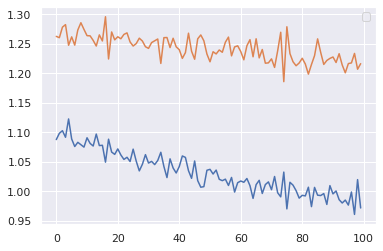

Time for epoch 10 is 0.8198575973510742 sec


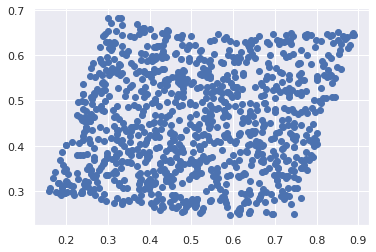

No handles with labels found to put in legend.


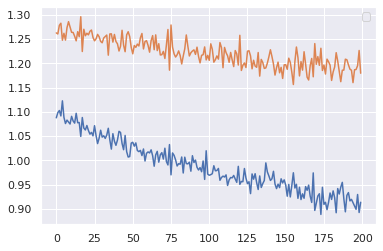

Time for epoch 20 is 0.8686177730560303 sec


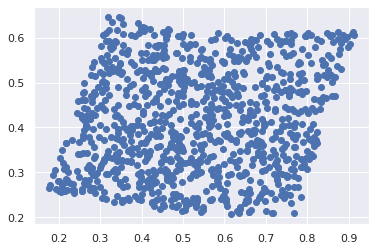

No handles with labels found to put in legend.


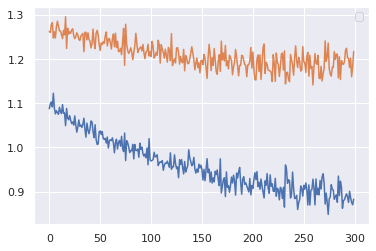

Time for epoch 30 is 0.8121464252471924 sec


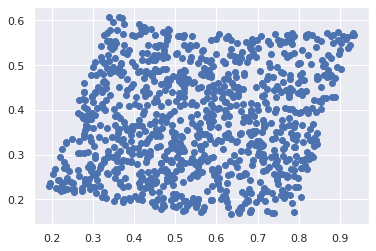

No handles with labels found to put in legend.


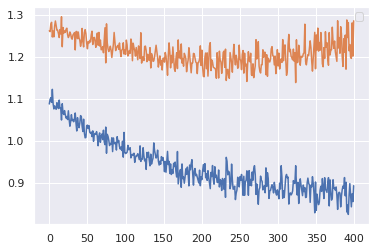

Time for epoch 40 is 0.8112192153930664 sec


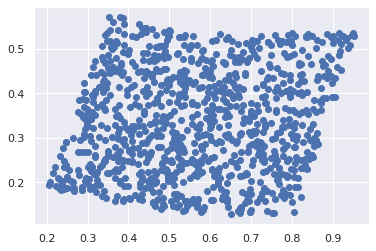

No handles with labels found to put in legend.


Time for epoch 50 is 0.8193025588989258 sec


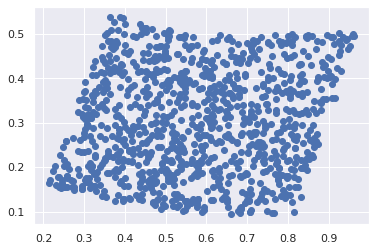

No handles with labels found to put in legend.


Time for epoch 60 is 0.801384687423706 sec


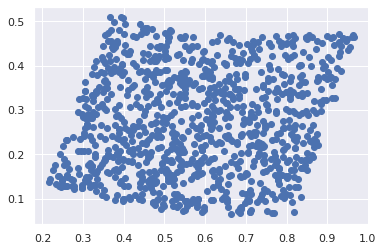

No handles with labels found to put in legend.


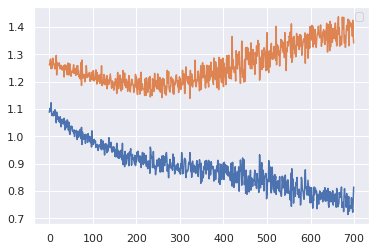

Time for epoch 70 is 0.8187158107757568 sec


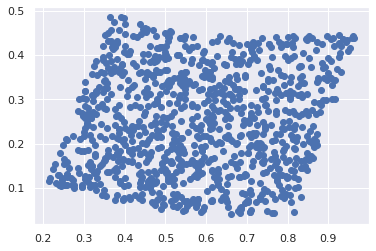

No handles with labels found to put in legend.


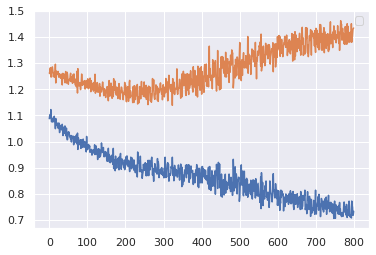

Time for epoch 80 is 0.8522989749908447 sec


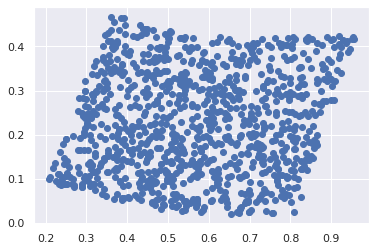

No handles with labels found to put in legend.


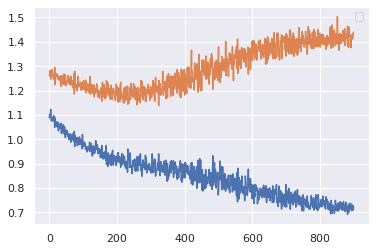

Time for epoch 90 is 0.83526611328125 sec


No handles with labels found to put in legend.


Time for epoch 100 is 0.8146493434906006 sec


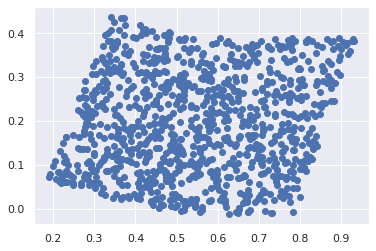

No handles with labels found to put in legend.


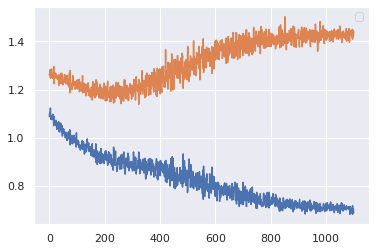

Time for epoch 110 is 0.8307328224182129 sec


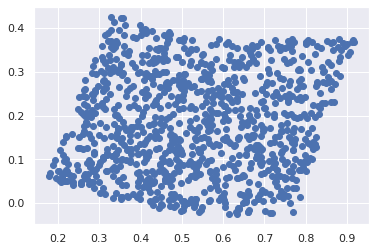

No handles with labels found to put in legend.


Time for epoch 120 is 1.1251018047332764 sec


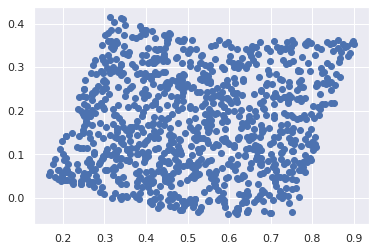

No handles with labels found to put in legend.


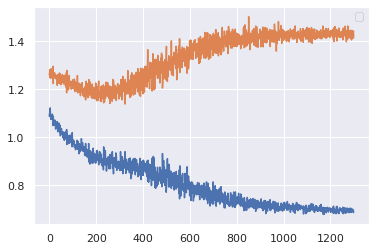

Time for epoch 130 is 0.83890700340271 sec


No handles with labels found to put in legend.


Time for epoch 140 is 0.851799488067627 sec


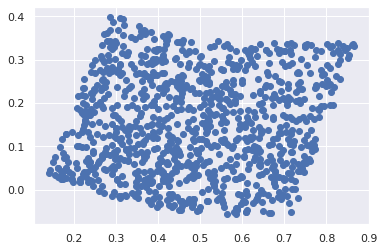

No handles with labels found to put in legend.


Time for epoch 150 is 0.8258872032165527 sec


No handles with labels found to put in legend.


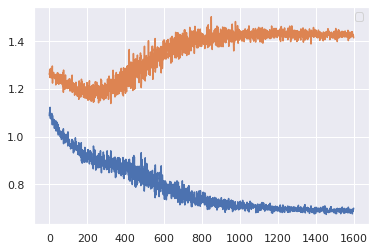

Time for epoch 160 is 0.84617018699646 sec


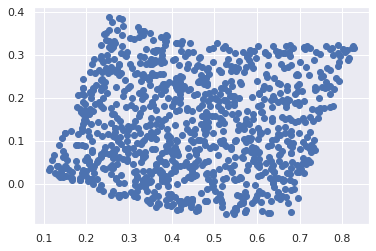

No handles with labels found to put in legend.


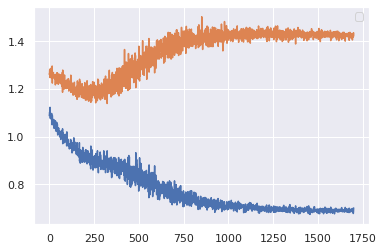

Time for epoch 170 is 0.8444042205810547 sec


No handles with labels found to put in legend.


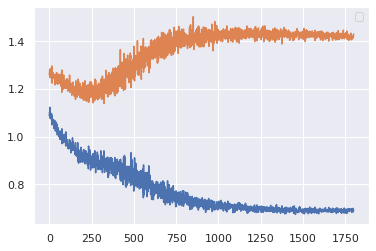

Time for epoch 180 is 0.8441455364227295 sec


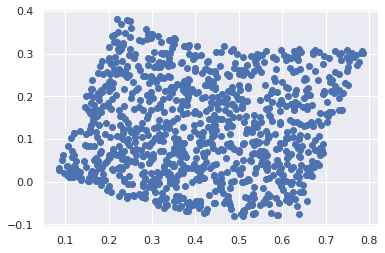

No handles with labels found to put in legend.


Time for epoch 190 is 0.8391563892364502 sec


No handles with labels found to put in legend.


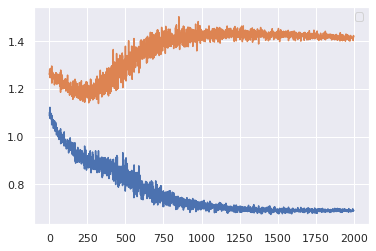

Time for epoch 200 is 0.8743066787719727 sec


No handles with labels found to put in legend.


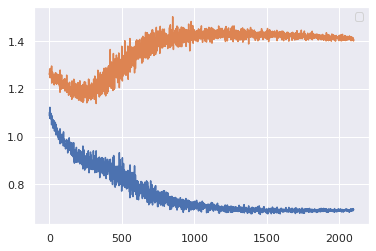

Time for epoch 210 is 0.8324024677276611 sec


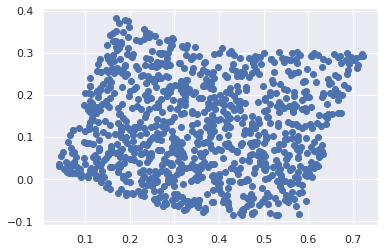

No handles with labels found to put in legend.


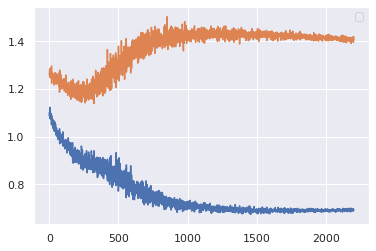

Time for epoch 220 is 0.8484866619110107 sec


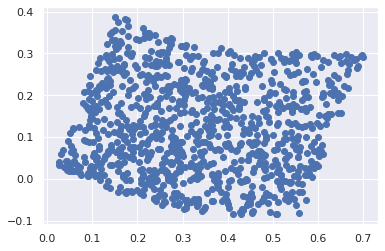

No handles with labels found to put in legend.


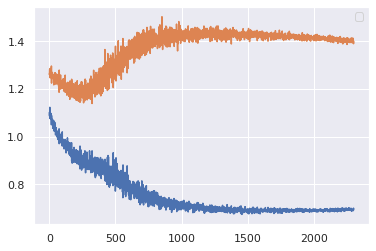

Time for epoch 230 is 0.8628311157226562 sec


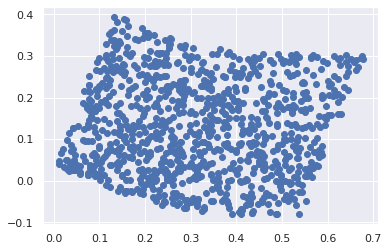

No handles with labels found to put in legend.


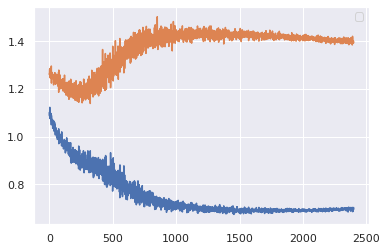

Time for epoch 240 is 0.8233809471130371 sec


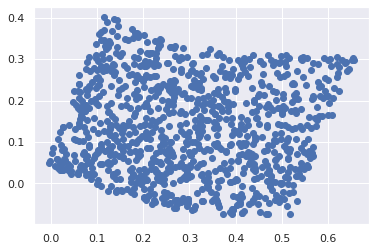

No handles with labels found to put in legend.


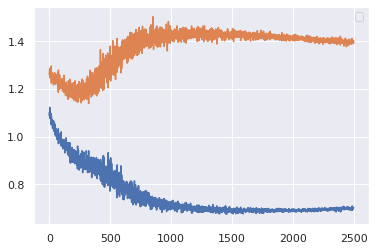

Time for epoch 250 is 0.823561429977417 sec


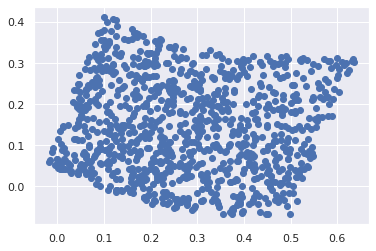

No handles with labels found to put in legend.


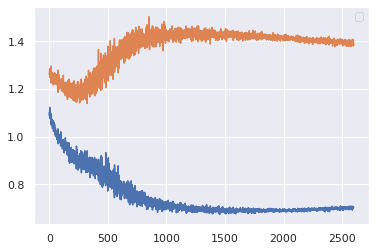

Time for epoch 260 is 0.8288388252258301 sec


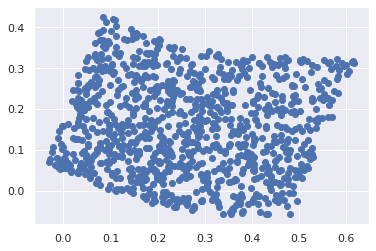

No handles with labels found to put in legend.


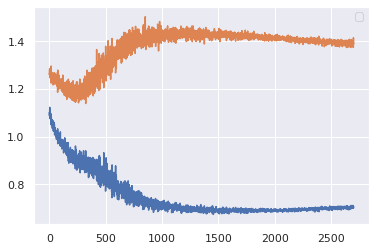

Time for epoch 270 is 0.8068509101867676 sec


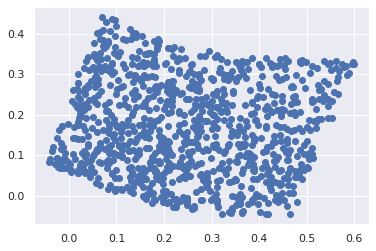

No handles with labels found to put in legend.


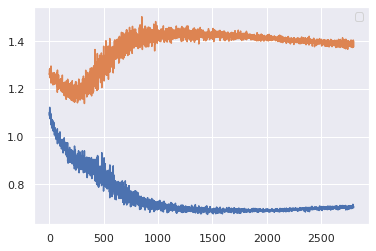

Time for epoch 280 is 0.8470120429992676 sec


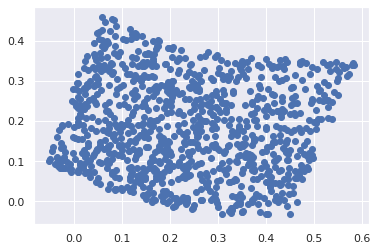

No handles with labels found to put in legend.


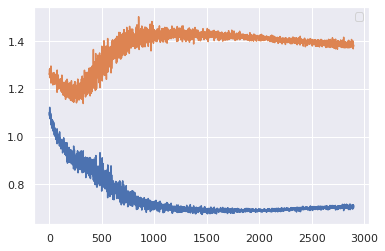

Time for epoch 290 is 1.190500020980835 sec


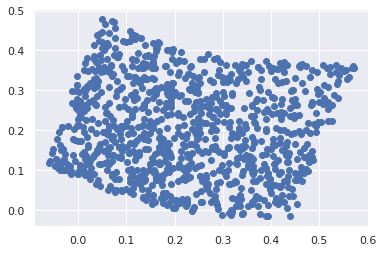

No handles with labels found to put in legend.


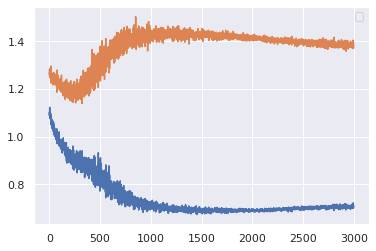

Time for epoch 300 is 0.9010601043701172 sec


No handles with labels found to put in legend.


Time for epoch 310 is 0.8674123287200928 sec


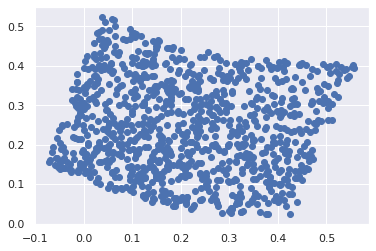

No handles with labels found to put in legend.


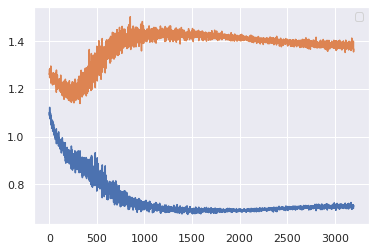

Time for epoch 320 is 0.8921499252319336 sec


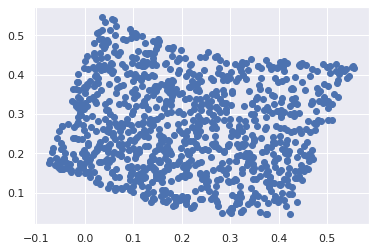

No handles with labels found to put in legend.


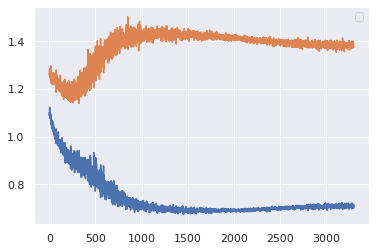

Time for epoch 330 is 0.9275970458984375 sec


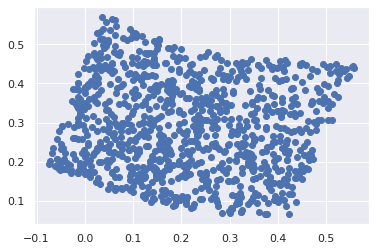

No handles with labels found to put in legend.


Time for epoch 340 is 0.8795862197875977 sec


No handles with labels found to put in legend.


Time for epoch 350 is 0.9172623157501221 sec


No handles with labels found to put in legend.


Time for epoch 360 is 0.8811304569244385 sec


No handles with labels found to put in legend.


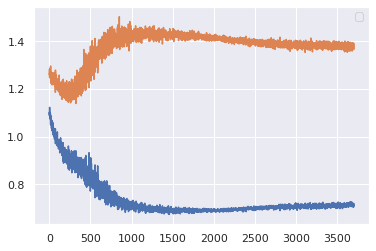

Time for epoch 370 is 0.8632028102874756 sec


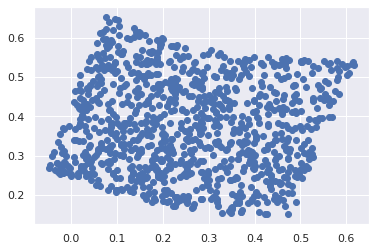

No handles with labels found to put in legend.


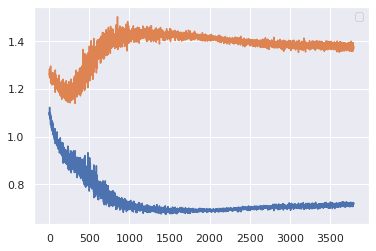

Time for epoch 380 is 0.8688950538635254 sec


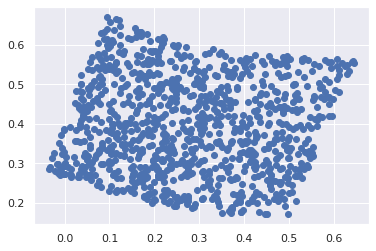

No handles with labels found to put in legend.


Time for epoch 390 is 0.8722841739654541 sec


No handles with labels found to put in legend.


Time for epoch 400 is 1.17313814163208 sec


No handles with labels found to put in legend.


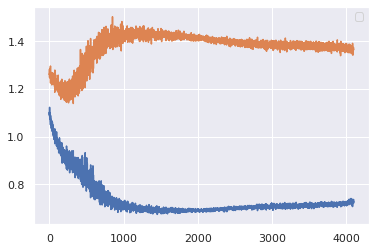

Time for epoch 410 is 0.8879790306091309 sec


No handles with labels found to put in legend.


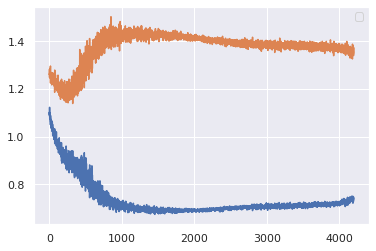

Time for epoch 420 is 0.8581700325012207 sec


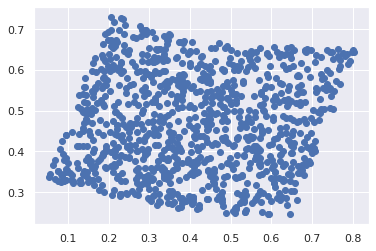

No handles with labels found to put in legend.


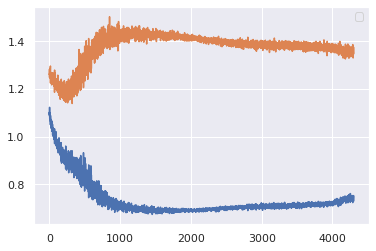

Time for epoch 430 is 0.8714649677276611 sec


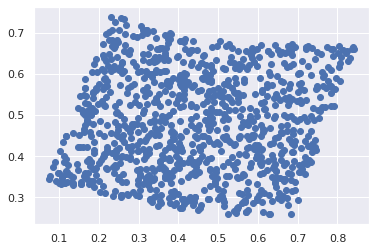

No handles with labels found to put in legend.


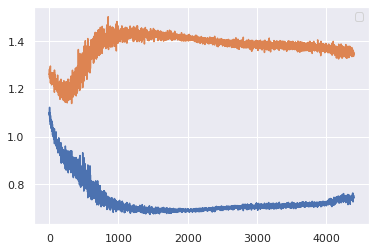

Time for epoch 440 is 0.8895812034606934 sec


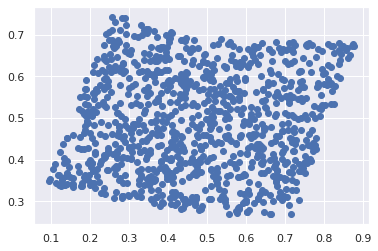

No handles with labels found to put in legend.


Time for epoch 450 is 0.9447333812713623 sec


No handles with labels found to put in legend.


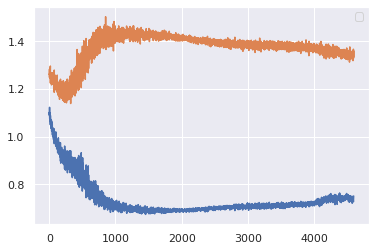

Time for epoch 460 is 0.8840680122375488 sec


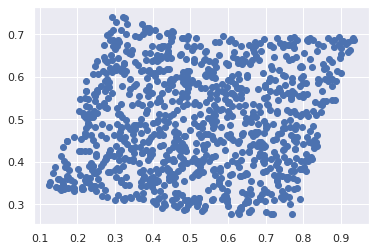

No handles with labels found to put in legend.


Time for epoch 470 is 1.1479623317718506 sec


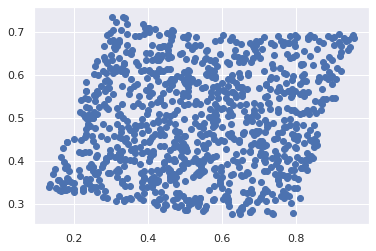

No handles with labels found to put in legend.


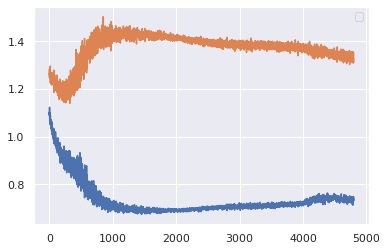

Time for epoch 480 is 0.8434262275695801 sec


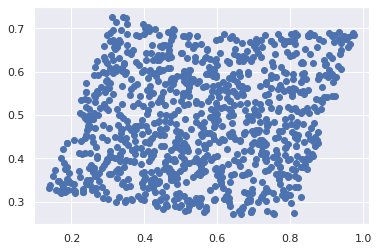

No handles with labels found to put in legend.


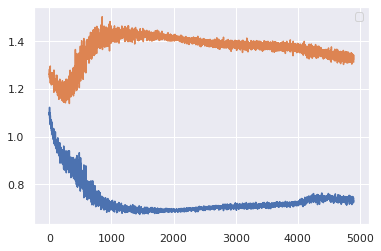

Time for epoch 490 is 0.8709666728973389 sec


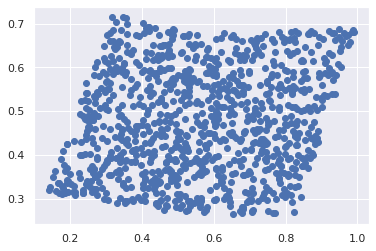

No handles with labels found to put in legend.


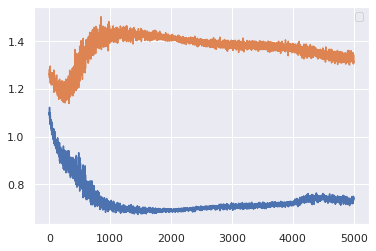

Time for epoch 500 is 0.8632090091705322 sec


No handles with labels found to put in legend.


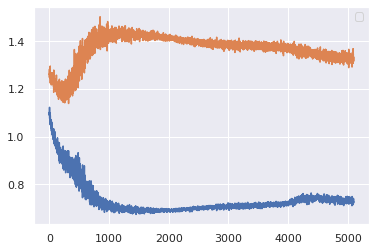

Time for epoch 510 is 0.8727660179138184 sec


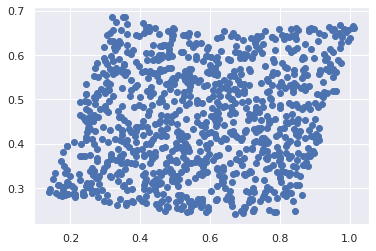

No handles with labels found to put in legend.


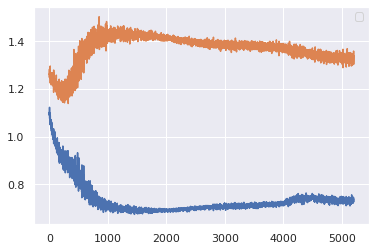

Time for epoch 520 is 0.8914949893951416 sec


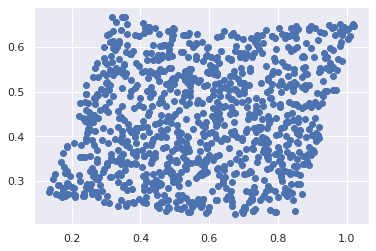

No handles with labels found to put in legend.


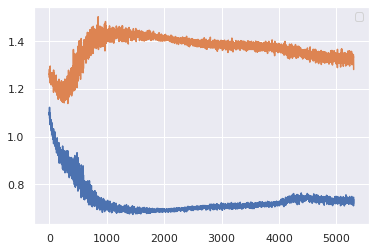

Time for epoch 530 is 0.8240194320678711 sec


No handles with labels found to put in legend.


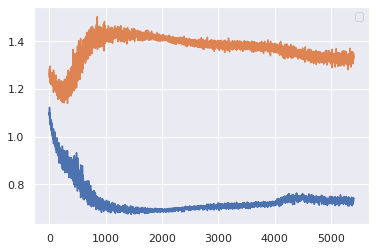

Time for epoch 540 is 1.139610767364502 sec


No handles with labels found to put in legend.


Time for epoch 550 is 0.8935542106628418 sec


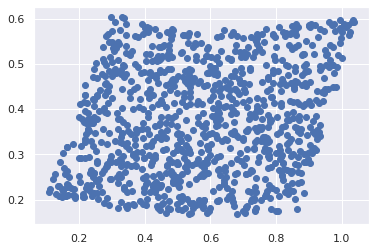

No handles with labels found to put in legend.


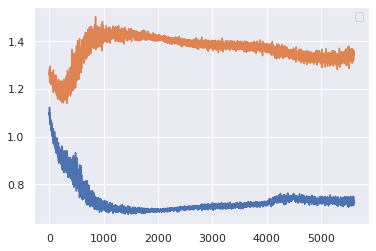

Time for epoch 560 is 0.9160721302032471 sec


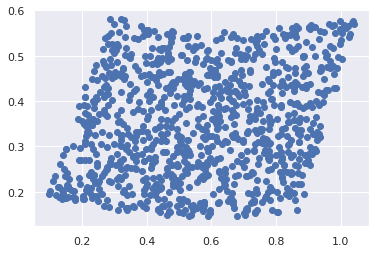

No handles with labels found to put in legend.


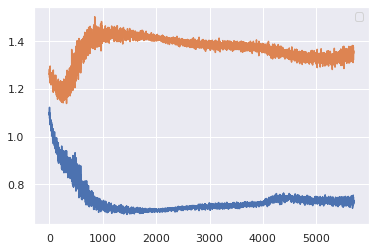

Time for epoch 570 is 0.8967723846435547 sec


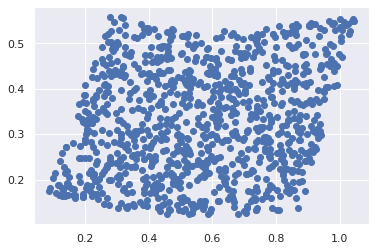

No handles with labels found to put in legend.


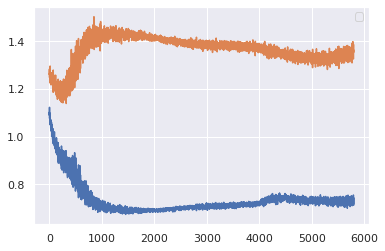

Time for epoch 580 is 0.9032671451568604 sec


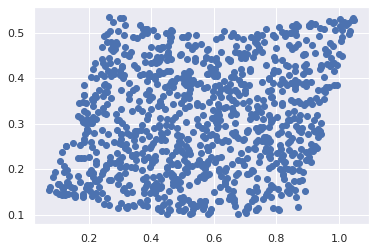

No handles with labels found to put in legend.


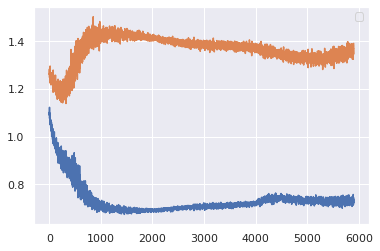

Time for epoch 590 is 0.9512784481048584 sec


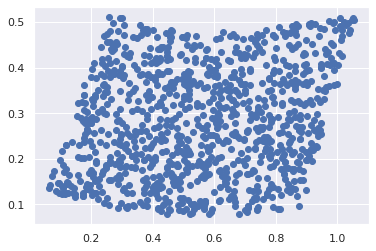

No handles with labels found to put in legend.


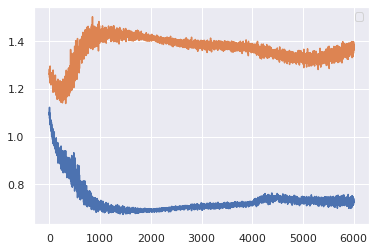

Time for epoch 600 is 0.9252088069915771 sec


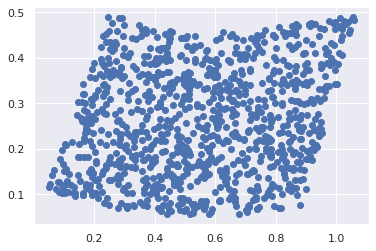

No handles with labels found to put in legend.


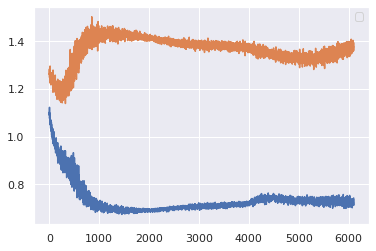

Time for epoch 610 is 1.9566938877105713 sec


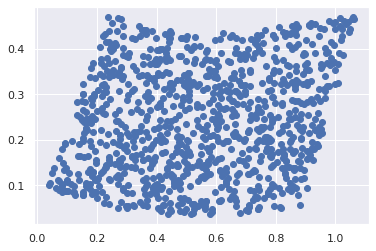

No handles with labels found to put in legend.


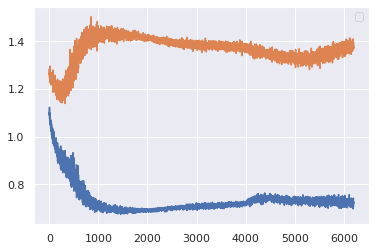

Time for epoch 620 is 0.8975021839141846 sec


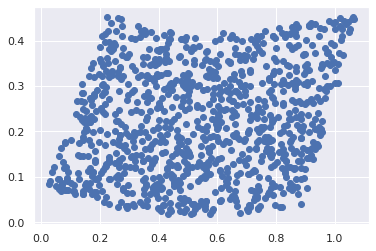

No handles with labels found to put in legend.


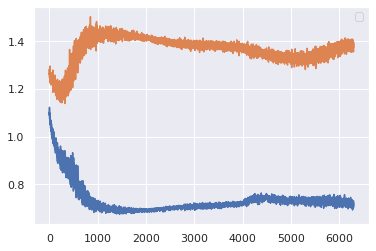

Time for epoch 630 is 0.893723726272583 sec


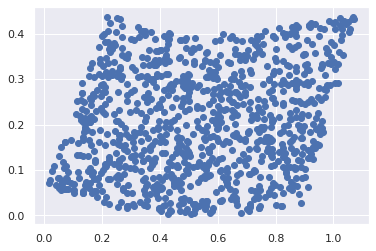

No handles with labels found to put in legend.


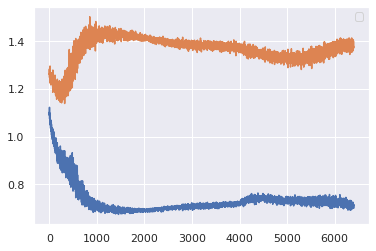

Time for epoch 640 is 0.9314842224121094 sec


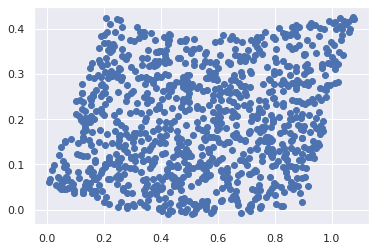

No handles with labels found to put in legend.


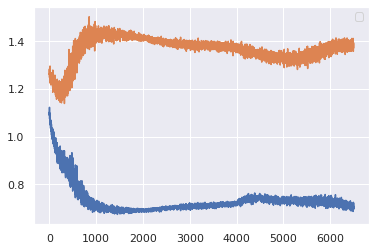

Time for epoch 650 is 0.9023127555847168 sec


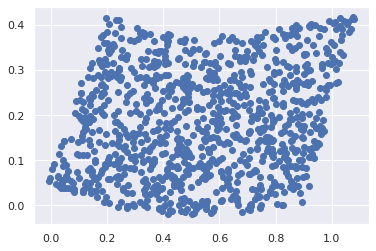

No handles with labels found to put in legend.


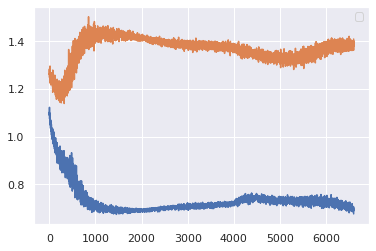

Time for epoch 660 is 0.9257829189300537 sec


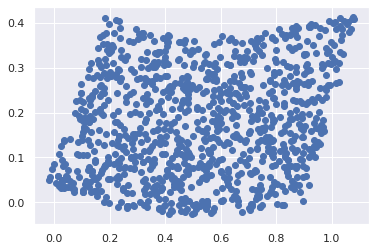

No handles with labels found to put in legend.


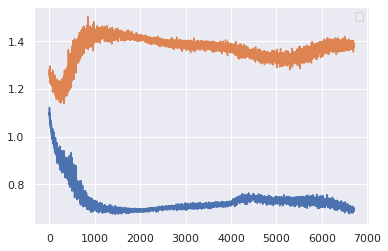

Time for epoch 670 is 1.1895971298217773 sec


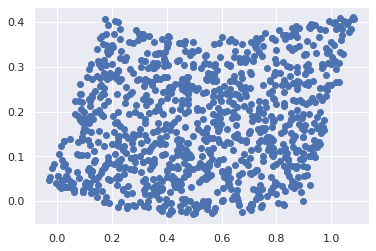

No handles with labels found to put in legend.


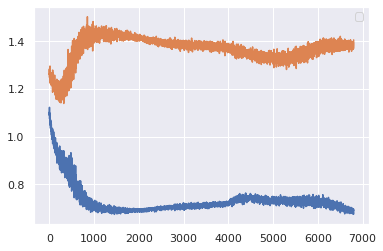

Time for epoch 680 is 0.9190042018890381 sec


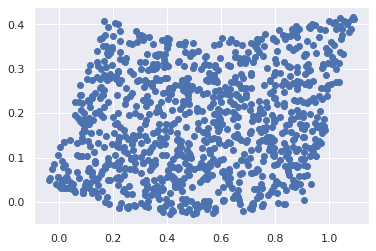

No handles with labels found to put in legend.


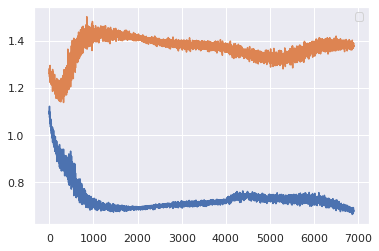

Time for epoch 690 is 0.9100527763366699 sec


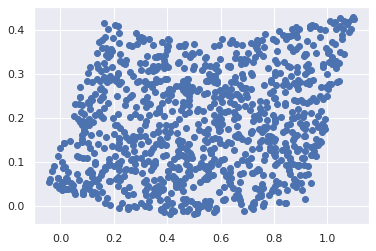

No handles with labels found to put in legend.


Time for epoch 700 is 0.9321198463439941 sec


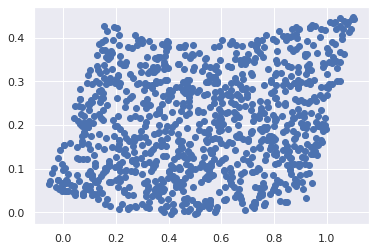

No handles with labels found to put in legend.


Time for epoch 710 is 0.9312319755554199 sec


No handles with labels found to put in legend.


Time for epoch 720 is 0.9219691753387451 sec


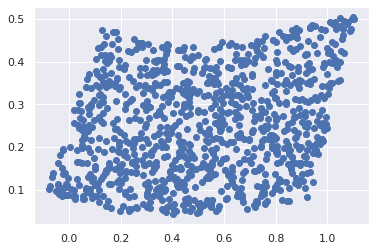

No handles with labels found to put in legend.


Time for epoch 730 is 1.190351963043213 sec


No handles with labels found to put in legend.


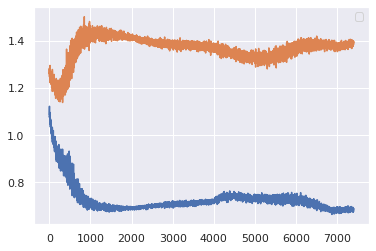

Time for epoch 740 is 0.9394378662109375 sec


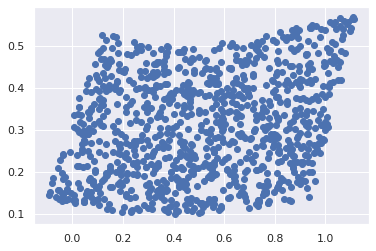

No handles with labels found to put in legend.


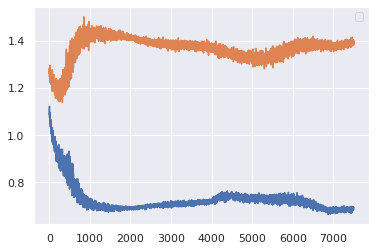

Time for epoch 750 is 0.889409065246582 sec


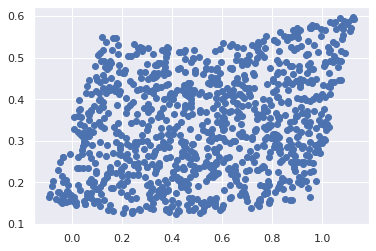

No handles with labels found to put in legend.


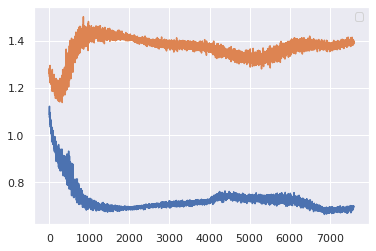

Time for epoch 760 is 0.9637570381164551 sec


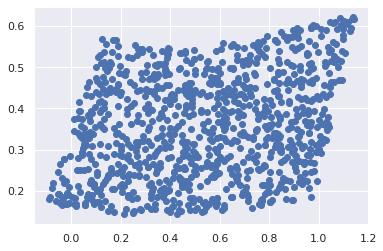

No handles with labels found to put in legend.


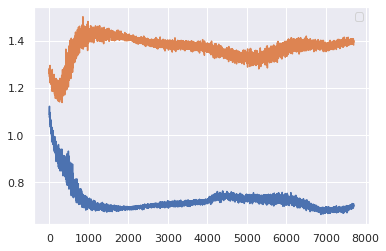

Time for epoch 770 is 0.9925820827484131 sec


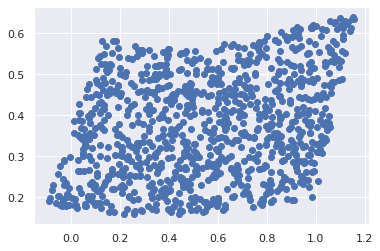

No handles with labels found to put in legend.


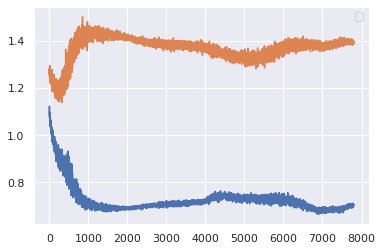

Time for epoch 780 is 1.1936562061309814 sec


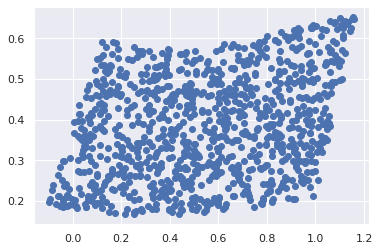

No handles with labels found to put in legend.


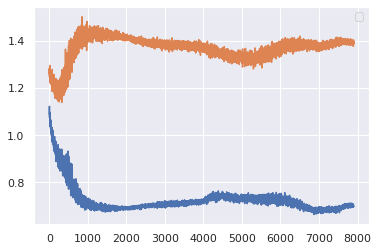

Time for epoch 790 is 0.9598605632781982 sec


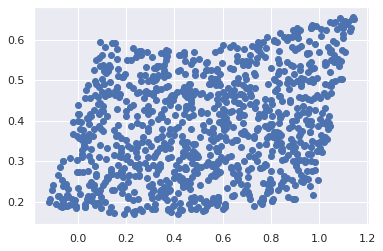

No handles with labels found to put in legend.


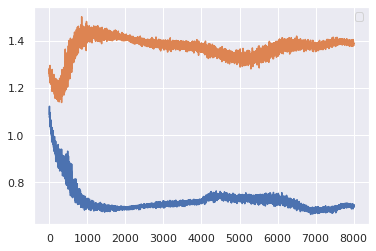

Time for epoch 800 is 1.0128159523010254 sec


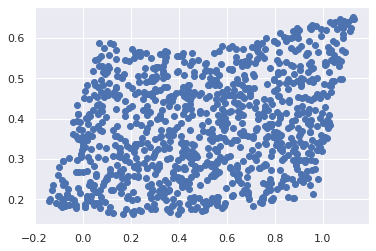

No handles with labels found to put in legend.


Time for epoch 810 is 0.97035813331604 sec


No handles with labels found to put in legend.


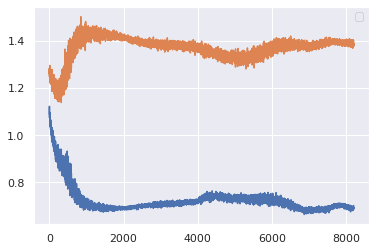

Time for epoch 820 is 1.1746749877929688 sec


No handles with labels found to put in legend.


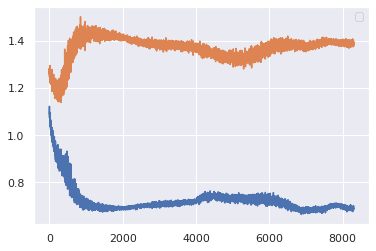

Time for epoch 830 is 0.9115128517150879 sec


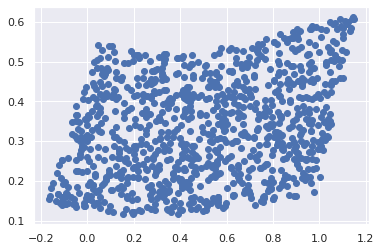

No handles with labels found to put in legend.


Time for epoch 840 is 0.9432034492492676 sec


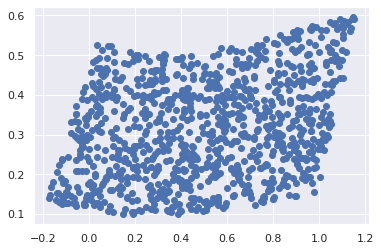

No handles with labels found to put in legend.


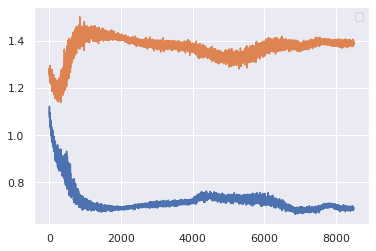

Time for epoch 850 is 0.9429044723510742 sec


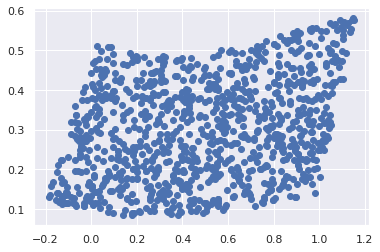

No handles with labels found to put in legend.


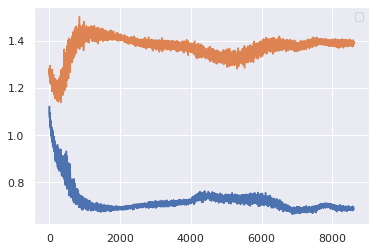

Time for epoch 860 is 1.1904566287994385 sec


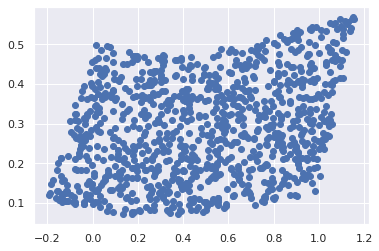

No handles with labels found to put in legend.


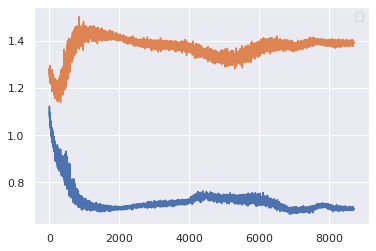

Time for epoch 870 is 0.9830317497253418 sec


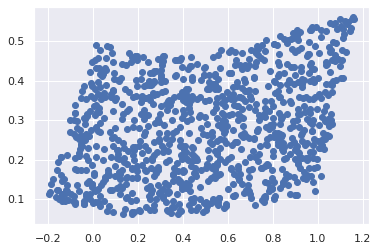

No handles with labels found to put in legend.


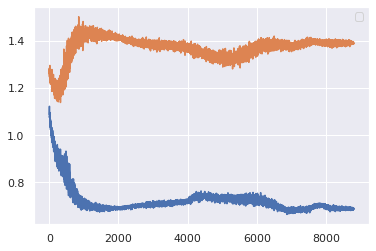

Time for epoch 880 is 0.9676439762115479 sec


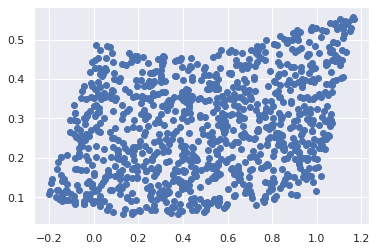

No handles with labels found to put in legend.


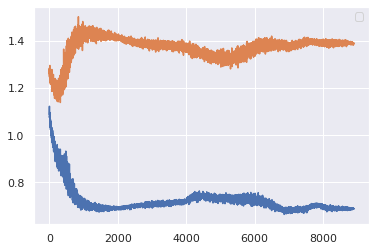

Time for epoch 890 is 0.9967334270477295 sec


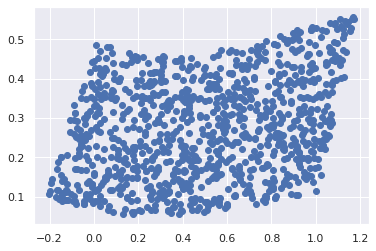

No handles with labels found to put in legend.


Time for epoch 900 is 1.1625456809997559 sec


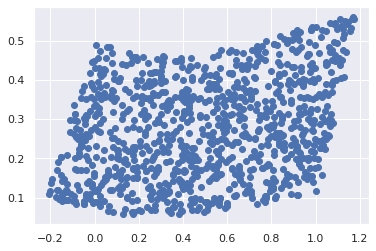

No handles with labels found to put in legend.


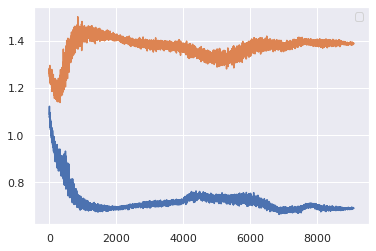

Time for epoch 910 is 0.9557833671569824 sec


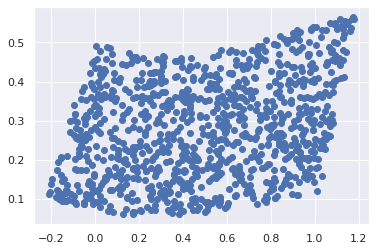

No handles with labels found to put in legend.


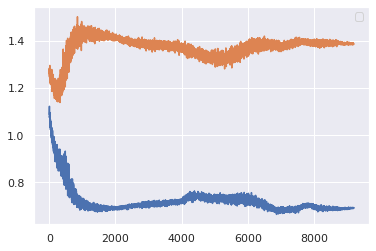

Time for epoch 920 is 0.9596660137176514 sec


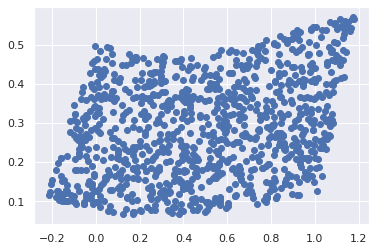

No handles with labels found to put in legend.


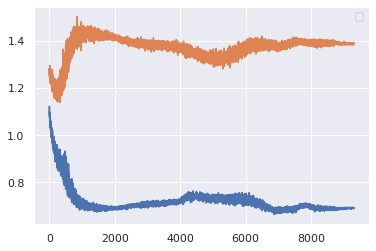

Time for epoch 930 is 0.9603917598724365 sec


No handles with labels found to put in legend.


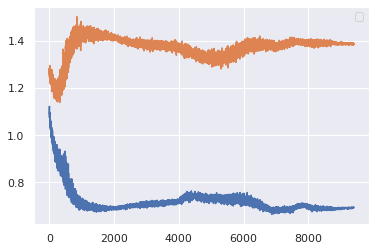

Time for epoch 940 is 1.265164852142334 sec


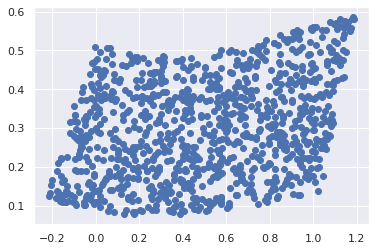

No handles with labels found to put in legend.


Time for epoch 950 is 0.9882614612579346 sec


No handles with labels found to put in legend.


Time for epoch 960 is 0.9725997447967529 sec


No handles with labels found to put in legend.


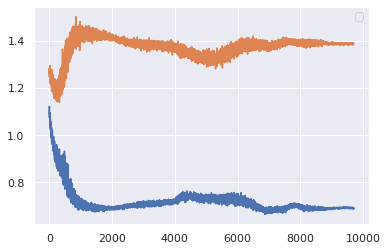

Time for epoch 970 is 1.2849268913269043 sec


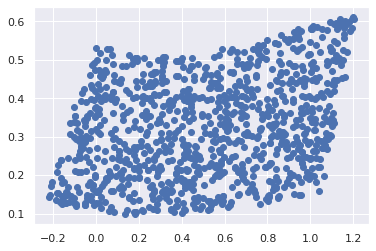

No handles with labels found to put in legend.


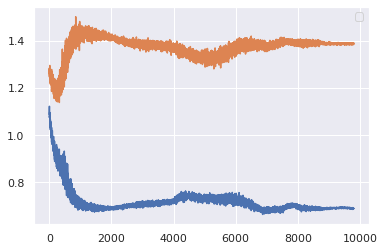

Time for epoch 980 is 1.0124893188476562 sec


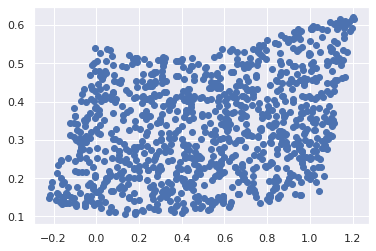

No handles with labels found to put in legend.


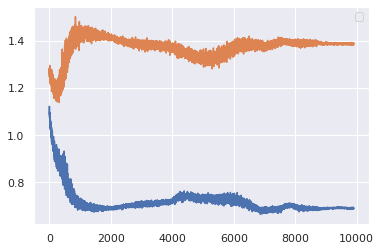

Time for epoch 990 is 1.0400300025939941 sec


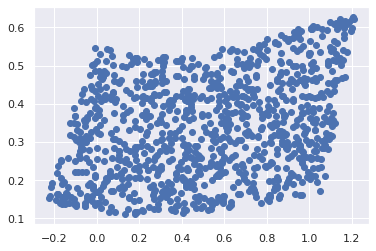

No handles with labels found to put in legend.


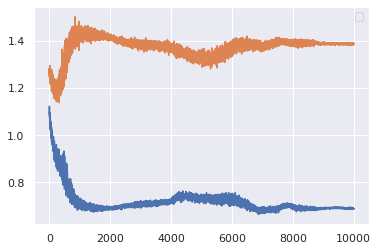

Time for epoch 1000 is 1.0039286613464355 sec


In [ ]:
gen_loss, disc_loss = train(train_dataset,1000)

In [ ]:
# #Save GAN
# f = plt.figure()
# plt.plot(gen_loss,label = r'Generator Loss',)
# plt.plot(disc_loss, label = r'Discriminator Loss')

# # set labels (LaTeX can be used)
# plt.title(r'\textbf{Implementing GAN, Loss over training steps}', fontsize=11)
# plt.xlabel(r'\textbf{Number of Training Steps}', fontsize=11)
# plt.ylabel(r'\textbf{Loss}', fontsize=11)
# ax = plt.axes()
# ax.set_facecolor("white")
# plt.legend('best')
# legend = plt.legend()
# frame = legend.get_frame()
# frame.set_facecolor('white')
# plt.grid(False)
# plt.show()

# # save as PDF
# f.savefig("GAN.pdf",bbox_inches='tight')

In [ ]:
# # Save evolution_freeze generator
# #Freeze Generator video
# rc('text', usetex=False)
# # Concat and extract all the states
# true_data = tf.random.uniform([1000,2],minval = [0,0], maxval = [1,0.5], dtype='float32')
# y_true = np.ones((1000,1))
# y_fake = np.zeros((1000,1))
# x_data = tf.concat([noise,true_data],axis = 0)
# y_data = np.concatenate([y_true,y_fake])


# states_concat = tf.concat([s[:, :, None] for s in states_G], axis=-1)
# states_model = tf.keras.Model(x1, states_concat)
# states_test = states_model.predict(x_data)

# # Extract the final layer (linear) classifier
# w, b = [w.numpy().squeeze() for w in last_layer.weights]

In [ ]:
# from matplotlib import pyplot as plt
# from matplotlib.ticker import MultipleLocator
# fig, ax = plt.subplots(2,2,figsize = (10,8))
# custom_xlim = (-2, 2)
# custom_ylim = (-2, 2)
# plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
# # fig.suptitle('Distribution of Points through the Process of Discriminator',fontweight ="bold")

# def draw(i,ax):
#   ax.scatter(
#     states_test[:1000, 0, i],
#     states_test[:1000, 1, i],
#     c='C0',
#     label = 'Fake'
#     )
#   ax.scatter(
#     states_test[1000:, 0, i],
#     states_test[1000:, 1, i],
#     c='C1',
#     label = 'True'
#     )
#   x1 = np.linspace(-2, 2, 100)
#   x2 = -(1/w[1]) * (w[0] * x1 + b)
#   ax.plot(x1, x2, color='black')
#   ax.grid(True, color = 'black', linewidth = 0.1)
#   ax.set_facecolor("white")
#   ax.set_title("t = "+str(i))
#   ax.xaxis.set_major_locator(MultipleLocator(1))
#   ax.yaxis.set_major_locator(MultipleLocator(1))
#   ax.legend()

# draw(0,ax[0,0])
# draw(5,ax[0,1])
# draw(10,ax[1,0])
# draw(20,ax[1,1])
# fig.savefig("Evo_1.pdf",bbox_inches='tight')

In [ ]:
# #Save Freeze_discriminater
# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('text', usetex=True)
# f = plt.figure()
# plt.plot(gen_loss,label = r'Generator Loss',)
# plt.plot(disc_loss, label = r'Discriminator Loss')

# # set labels (LaTeX can be used)
# plt.title(r'\textbf{Freeze discriminator, Loss over training steps}', fontsize=11)
# plt.xlabel(r'\textbf{Number of Training Steps}', fontsize=11)
# plt.ylabel(r'\textbf{Loss}', fontsize=11)
# ax = plt.axes()
# ax.set_facecolor("white")
# plt.legend()
# legend = plt.legend()
# frame = legend.get_frame()
# frame.set_facecolor('white')
# plt.grid(False)
# plt.show()

# # save as PDF
# f.savefig("Freeze_discriminater.pdf",bbox_inches='tight')

In [ ]:
# # Save Freeze_generator
# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('text', usetex=True)
# f = plt.figure()
# plt.plot(gen_loss,label = r'Generator Loss',)
# plt.plot(disc_loss, label = r'Discriminator Loss')

# # set labels (LaTeX can be used)
# plt.title(r'\textbf{Freeze Generator, Loss over training steps}', fontsize=11)
# plt.xlabel(r'\textbf{Number of Training Steps}', fontsize=11)
# plt.ylabel(r'\textbf{Loss}', fontsize=11)
# ax = plt.axes()
# ax.set_facecolor("white")
# plt.legend()
# legend = plt.legend()
# frame = legend.get_frame()
# frame.set_facecolor('white')
# plt.grid(False)
# plt.show()

# # save as PDF
# f.savefig("Freeze_generator.pdf",bbox_inches='tight')

In [ ]:
# #Freeze Discriminator video
# from matplotlib.animation import FuncAnimation
# from matplotlib import animation
# from IPython.display import HTML
# # Concat and extract all the states
# states_concat = tf.concat([s[:, :, None] for s in states_G], axis=-1)
# states_model = tf.keras.Model(x0, states_concat)
# states_test = states_model.predict(noise)
# # Extract the final layer (linear) classifier
# # w, b = [w.numpy().squeeze() for w in last_layer.weights]

# fig, ax = plt.subplots()

# ax.set_xlim(-2, 2)
# ax.set_ylim(-2, 2)

# scat = ax.scatter(
#     states_test[:, 0, 0],
#     states_test[:, 1, 0],
# )

# def animate(i):
#     ax.axhline(0.5,color = 'black')
#     ax.axhspan(-2, 0.5, alpha=0.01,color = 'grey')
#     scat.set_offsets(states_test[:, :, i])
#     ax.set_title(r'\textbf{Distribution over Time under the Generator when t = }'+r'\textbf{{{time}}}'.format(time = str(i)))
#     ax.grid(True, color = 'black', linewidth = 0.1)
#     ax.set_facecolor("white")

#     # x1 = np.linspace(-2, 2, 100)
#     # x2 = -(1/w[1]) * (w[0] * x1 + b)
#     # ax.plot(x1, x2, color='black')
#     return (scat,)


# anim = FuncAnimation(fig, animate, frames=n_g_layers, interval=200)
# writervideo = animation.FFMpegWriter(fps=2) 
# anim.save('Freeze_discriminator.mp4', writer=writervideo)
# HTML(anim.to_html5_video())

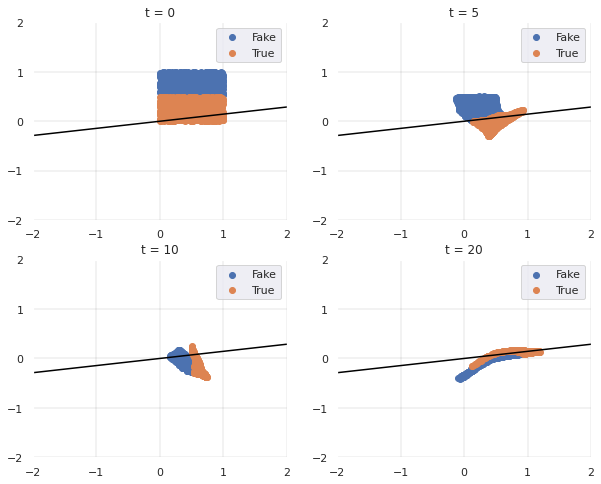

In [ ]:
# GAN_discriminator
# Concat and extract all the states
true_data = tf.random.uniform([1000,2],minval = [0,0], maxval = [1,0.5], dtype='float32')
y_true = np.ones((1000,1))
y_fake = np.zeros((1000,1))
x_data = tf.concat([noise,true_data],axis = 0)
y_data = np.concatenate([y_true,y_fake])


states_concat = tf.concat([s[:, :, None] for s in states_D], axis=-1)
states_model = tf.keras.Model(x1, states_concat)
states_test = states_model.predict(x_data)

# Extract the final layer (linear) classifier
w, b = [w.numpy().squeeze() for w in last_layer.weights]
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(2,2,figsize = (10,8))
custom_xlim = (-2, 2)
custom_ylim = (-2, 2)
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
# fig.suptitle('Distribution of Points through the Process of Discriminator',fontweight ="bold")

def draw(i,ax):
  ax.scatter(
    states_test[:1000, 0, i],
    states_test[:1000, 1, i],
    c='C0',
    label = 'Fake'
    )
  ax.scatter(
    states_test[1000:, 0, i],
    states_test[1000:, 1, i],
    c='C1',
    label = 'True'
    )
  x1 = np.linspace(-2, 2, 100)
  x2 = -(1/w[1]) * (w[0] * x1 + b)
  ax.plot(x1, x2, color='black')
  ax.grid(True, color = 'black', linewidth = 0.1)
  ax.set_facecolor("white")
  ax.set_title("t = "+str(i))
  ax.xaxis.set_major_locator(MultipleLocator(1))
  ax.yaxis.set_major_locator(MultipleLocator(1))
  ax.legend()

draw(0,ax[0,0])
draw(5,ax[0,1])
draw(10,ax[1,0])
draw(20,ax[1,1])
fig.savefig("Evo_4.pdf",bbox_inches='tight')

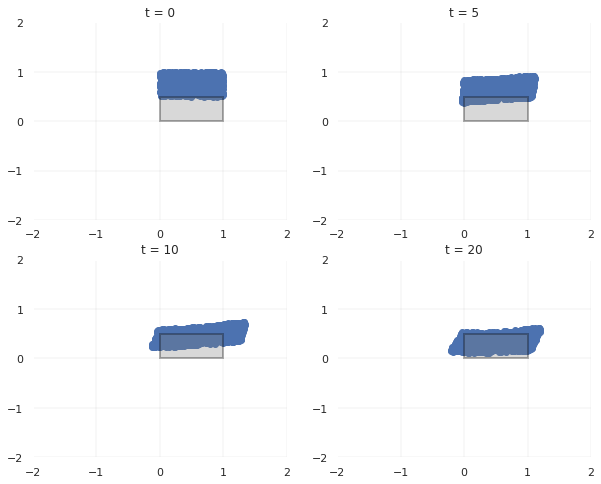

In [ ]:
#GAN_GEN
# Concat and extract all the states
import matplotlib.patches as patches
states_concat = tf.concat([s[:, :, None] for s in states_G], axis=-1)
states_model = tf.keras.Model(x0, states_concat)
states_test = states_model.predict(noise)

from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(2,2,figsize = (10,8))
custom_xlim = (-2, 2)
custom_ylim = (-2, 2)
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)


def draw(i,ax):
  ax.scatter(
    states_test[:, 0, i],
    states_test[:, 1, i],
    )
  rect = patches.Rectangle((0, 0), 1, 0.5, linewidth=2, edgecolor='black', facecolor='grey',alpha = 0.3)
  ax.add_patch(rect)
  ax.grid(True, alpha = 0.5, color = 'black', linewidth = 0.1)
  ax.set_facecolor("white")
  ax.set_title("t = "+str(i))
  ax.xaxis.set_major_locator(MultipleLocator(1))
  ax.yaxis.set_major_locator(MultipleLocator(1))

draw(0,ax[0,0])
draw(5,ax[0,1])
draw(10,ax[1,0])
draw(20,ax[1,1])
fig.savefig("Evo_3.pdf",bbox_inches='tight')

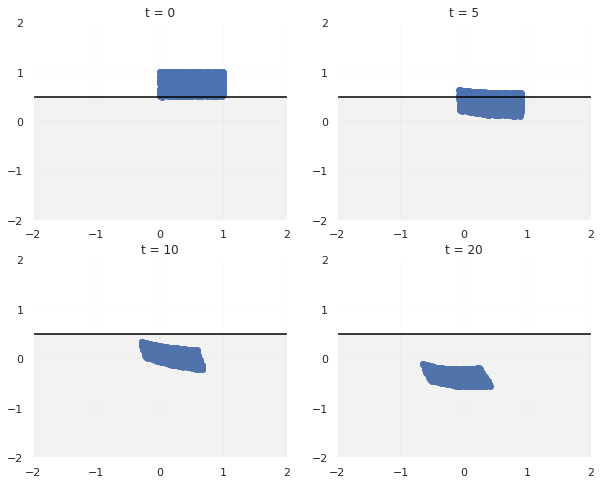

In [ ]:
# #Freeze Generator picture
# # Concat and extract all the states
# states_concat = tf.concat([s[:, :, None] for s in states_G], axis=-1)
# states_model = tf.keras.Model(x0, states_concat)
# states_test = states_model.predict(noise)

# from matplotlib import pyplot as plt
# from matplotlib.ticker import MultipleLocator
# fig, ax = plt.subplots(2,2,figsize = (10,8))
# custom_xlim = (-2, 2)
# custom_ylim = (-2, 2)
# plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)


# def draw(i,ax):
#   ax.scatter(
#     states_test[:, 0, i],
#     states_test[:, 1, i],
#     )
#   ax.axhline(0.5,color = 'black')
#   ax.axhspan(-2, 0.5, alpha=0.1,color = 'grey')
#   ax.grid(True, alpha = 0.2, color = 'black', linewidth = 0.1)
#   ax.set_facecolor("white")
#   ax.set_title("t = "+str(i))
#   ax.xaxis.set_major_locator(MultipleLocator(1))
#   ax.yaxis.set_major_locator(MultipleLocator(1))

# draw(0,ax[0,0])
# draw(5,ax[0,1])
# draw(10,ax[1,0])
# draw(20,ax[1,1])
# fig.savefig("Evo_2.pdf",bbox_inches='tight')

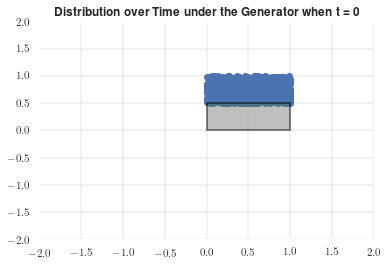

In [ ]:
#GAN_generator video
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from IPython.display import HTML
# Concat and extract all the states
states_concat = tf.concat([s[:, :, None] for s in states_G], axis=-1)
states_model = tf.keras.Model(x0, states_concat)
states_test = states_model.predict(noise)
# Extract the final layer (linear) classifier
# w, b = [w.numpy().squeeze() for w in last_layer.weights]

fig, ax = plt.subplots()

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

scat = ax.scatter(
    states_test[:, 0, 0],
    states_test[:, 1, 0],
)

def animate(i):
    scat.set_offsets(states_test[:, :, i])
    rect = patches.Rectangle((0, 0), 1, 0.5, linewidth=2, edgecolor='black', facecolor='grey',alpha = 0.01)
    ax.add_patch(rect)
    ax.set_title(r'\textbf{Distribution over Time under the Generator when t = }'+r'\textbf{{{time}}}'.format(time = str(i)))
    ax.grid(True, color = 'black', linewidth = 0.1)
    ax.set_facecolor("white")

    # x1 = np.linspace(-2, 2, 100)
    # x2 = -(1/w[1]) * (w[0] * x1 + b)
    # ax.plot(x1, x2, color='black')
    return (scat,)


anim = FuncAnimation(fig, animate, frames=n_g_layers, interval=200)
writervideo = animation.FFMpegWriter(fps=1.5) 
anim.save('GAN_generator.mp4', writer=writervideo)
HTML(anim.to_html5_video())

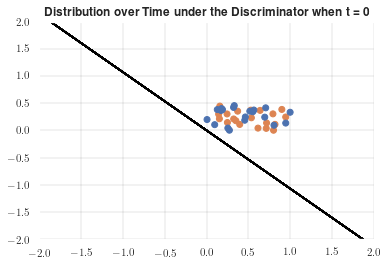

In [ ]:
#GAN_Discriminator video
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from IPython.display import HTML
# Concat and extract all the states
test_size = 20
true_data = tf.random.uniform([test_size,2],minval = [0,0], maxval = [1,0.5], dtype='float32')
noise = tf.random.uniform([test_size,2],minval = [0,0.5], maxval = [1,1], dtype='float32')
y_true = np.ones((test_size,1))
y_fake = np.zeros((test_size,1))
generated_data = model_generator.predict(noise)
x_data = tf.concat([generated_data,true_data],axis = 0)
y_data = np.concatenate([y_true,y_fake])


states_concat = tf.concat([s[:, :, None] for s in states_D], axis=-1)
states_model = tf.keras.Model(x1, states_concat)
states_test = states_model.predict(x_data)

# Extract the final layer (linear) classifier
w, b = [w.numpy().squeeze() for w in last_layer.weights]

fig, ax = plt.subplots()

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)


scat = ax.scatter(
    states_test[:, 0, 0],
    states_test[:, 1, 0],
    c=['C0' if y==0 else 'C1' for y in y_data],
)



def animate(i):
    scat.set_offsets(states_test[:, :, i])
    x1 = np.linspace(-2, 2, 100)
    x2 = -(1/w[1]) * (w[0] * x1 + b)
    ax.plot(x1, x2, color='black')
    ax.set_title(r'\textbf{Distribution over Time under the Discriminator when t = }'+r'\textbf{{{time}}}'.format(time = str(i)))
    ax.grid(True, color = 'black', linewidth = 0.1)
    ax.set_facecolor("white")
    return (scat,)


anim = FuncAnimation(fig, animate, frames=n_g_layers, interval=200)
writervideo = animation.FFMpegWriter(fps=2) 
anim.save('GAN_Discriminator.mp4', writer=writervideo)
HTML(anim.to_html5_video())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')